In [1]:
# Imports
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA 
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
import nltk
for package in ['stopwords','punkt','wordnet', 'omw-1.4']:
    nltk.download(package) 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
import xgboost as xgb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [2]:
train_df = pd.read_csv("train.csv.zip")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


There are no nulls.

### View Dataset Balance ###

In [4]:
# Target column names
target_cols = train_df.iloc[:,2:].columns.to_list()
target_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
# View dataset balance and establish baseline accuracy
for column in target_cols:
    print(train_df[column].value_counts())
    print("Accuracy if all classifed as '0':", train_df[column].value_counts().loc[0] / (train_df[column].value_counts().loc[0] + train_df[column].value_counts().loc[1]))
    print()

0    144277
1     15294
Name: toxic, dtype: int64
Accuracy if all classifed as '0': 0.9041555169799024

0    157976
1      1595
Name: severe_toxic, dtype: int64
Accuracy if all classifed as '0': 0.9900044494300343

0    151122
1      8449
Name: obscene, dtype: int64
Accuracy if all classifed as '0': 0.947051782592075

0    159093
1       478
Name: threat, dtype: int64
Accuracy if all classifed as '0': 0.9970044682304429

0    151694
1      7877
Name: insult, dtype: int64
Accuracy if all classifed as '0': 0.9506363938309592

0    158166
1      1405
Name: identity_hate, dtype: int64
Accuracy if all classifed as '0': 0.9911951419744189



### Sample Data for Model Tuning and Creation ###

In [6]:
train_df_0 = train_df[train_df.iloc[:, 2:].sum(axis=1) == 0] # rows that have all 0 in target columns
train_df_1 = train_df[train_df.iloc[:, 2:].sum(axis=1) != 0] # rows that have at least one 1 in one of the target columns
print('All 0:', len(train_df_0))
print('Some 1:', len(train_df_1))

All 0: 143346
Some 1: 16225


In [7]:
# View some angry comments
train_df_1.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5121,0d93cbb6f05d0d04,should we mention that this beer nearly tops t...,1,0,0,0,0,0
58324,9c22d6ac32c484e7,"-This artcicle is a God Damn joke, it shouldnt...",1,0,1,0,1,0
82047,db7cb0618d6e597e,Show up again when you figure out how to rub t...,1,0,0,0,1,0
87050,e8d9aa36aa2bd503,"In between the rapes, torture and murder I do ...",1,0,1,0,0,0
139856,ec781192de6916a7,I'm gonna fuck you up sand niger!,1,1,1,0,1,1


In [8]:
# Create a "more" balanced sample so we can account for more 'angry' comments when training and tuning
# train_df_0 = train_df_0.sample(30000) 
# train_df_1 = train_df_1.sample(15000)
# train_df_ = pd.concat([train_df_1, train_df_0], axis=0, ignore_index=True)

In [9]:
train_df_ = train_df # to see train test split results on all of training data

In [10]:
# View target balance of our sample
for column in target_cols:
    print(train_df_[column].value_counts())
    print("Accuracy if all classifed as '0':", train_df_[column].value_counts().loc[0] / (train_df_[column].value_counts().loc[0] + train_df_[column].value_counts().loc[1]))
    print()

0    144277
1     15294
Name: toxic, dtype: int64
Accuracy if all classifed as '0': 0.9041555169799024

0    157976
1      1595
Name: severe_toxic, dtype: int64
Accuracy if all classifed as '0': 0.9900044494300343

0    151122
1      8449
Name: obscene, dtype: int64
Accuracy if all classifed as '0': 0.947051782592075

0    159093
1       478
Name: threat, dtype: int64
Accuracy if all classifed as '0': 0.9970044682304429

0    151694
1      7877
Name: insult, dtype: int64
Accuracy if all classifed as '0': 0.9506363938309592

0    158166
1      1405
Name: identity_hate, dtype: int64
Accuracy if all classifed as '0': 0.9911951419744189



In [11]:
x_ = train_df_['comment_text']
y_ = train_df_[target_cols] # Y contains multiple columns for our MultiOutputClassifier

### Process the Training Data ###

Defining a Preprocessing Function:

<ul>
<li> The preprocess function is designed to preprocess individual text documents by removing unnecessary words, characters, and noise that may not be useful for downstream analysis.
<li> The preprocessor will be applied to the training data and the test data so it is ready for the next steps in the model.
<li> It takes into account things like punctuation and different formats of words so our testing data is more likely to the recognized by the our model.
</ul>

In [12]:
stop_words = set(stopwords.words('english')) # list of stop words 

# Separate text into list of lemmatized tokens
class preprocess(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                tok = re.sub('\W+','', tok) # Punctuation strip
                tmp = self.lemmatizer.lemmatize(tok)
                if len(tmp) >= 1: 
                    filtered_tok.append(tok)
        return " ".join(filtered_tok)

Applying Preprocessor function to Our Training Dataset:
<ul>
<li> Each comment of our training dataset will be cleaned with out preprocessor and stored in a variable 'x_clean'
</ul>

In [13]:
# preprocess text with stop words from NLTK
clean = preprocess(stop_words)
x_clean = [clean(x) for x in x_]

Train-Test Split
<ul>
<li> Split the data into training and testing sets so we can evaluate our accuracy on populated target columns
</ul>

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y_, test_size=0.2)

### Word2Vec ###

<ul>
<li> We ran multiple trials and models with a Word2Vec model assuming that it's more advanced algorithms could capture relationships between 'trigger' words that would help classify angry texts.
<li> Most of the models did a poor job at classifying angry texts, usually labelling everything as 0. 
<li> Ultimately, we had better results from TF-IDF vectorization. 
<li> This section is commented out but includes some of the trials we did with Word2Vec.
</ul>

Why might TF-IDF be better than Word2Vec?
<ul>
<li> MeanEmbeddingVectorizer for Word2Vec averages scores of tokens in a comment together, potentially making trigger words harder to recognize for our classifiers
<li> TF-IDF may weight important words in the training corpus more effectively, lowering scores of too frequent and too rare words
</ul>

In [15]:
# Train test split 
# x = train_df_['comment_text']
# y = train_df_[target_cols]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
# # Tokenize train and test split of training data
# x_train_tok = [tok(x) for x in x_train]
# x_test_tok = [tok(x) for x in x_test]

In [17]:
# Assign list of tokens an average value for each vector
# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = len(next(iter(word2vec.values())))

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

In [18]:
# # Train Word2Vec model with tokenized train split, words evaluated in 200 dimensions
# w2v_model = Word2Vec(x_train_tok, min_count=1, vector_size=300) 
# w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors)) # 'scores' for each word in 200 dimensions

In [19]:
# # Give mean score for comment in each of the 200 dimensions
# # train split and test split need to be in the same format to be plugged into model
# model_ = MeanEmbeddingVectorizer(w2v) 
# x_train_vectors_w2v = model_.transform(x_train_tok) 
# x_val_vectors_w2v = model_.transform(x_test_tok)

In [20]:
# # LinearSVC with tuning to find hyperparameters that improve accuracy
# clf2 = LinearSVC(dual=False, C=2)

# pipe_steps2 = [
#     ("scale", MinMaxScaler()), 
#     ("kernel_approx", Nystroem(n_components=100, kernel='linear')),
#     ("model", MultiOutputClassifier(clf2))
#     ]
# pipe_2 = Pipeline(steps=pipe_steps2)

# # params = {
# # #     # "kernel_approx__kernel": ['linear', 'poly', 'rbf'], # Linear was best
# #     # "model__estimator__C": [1, 2, 3, 4, 5], # 2 was best
# # #     # "model__estimator__class_weight": [{0: 0.5, 1: 3}, {0: 0.5, 1: 2}, {0: 1, 1: 2}, {0: 1, 1: 1}], # weights C differently for each class to adjust for imbalance, 1 and 1 was best
# #     }
# # grid_model = GridSearchCV(estimator=pipe_2, param_grid=params, n_jobs=-1) 

# # grid_model.fit(x_train_vectors_w2v, y_train)
# # best = grid_model.best_estimator_
# best = pipe_2
# best.fit(x_train_vectors_w2v, y_train)

In [21]:
# best

In [22]:
# preds2 = best.predict(x_val_vectors_w2v)
# pred2_df = pd.DataFrame(preds2, columns=target_cols)

In [23]:
# for column in pred2_df.columns:
#     print(column)
#     print('Accuracy:', accuracy_score(y_test[column], pred2_df[column]))
#     print(classification_report(y_test[column], pred2_df[column], zero_division=1))
#     sns.heatmap(confusion_matrix(y_test[column], pred2_df[column]), annot=True)
#     plt.show()

### Classification Model ###

Out of the classifiers we tested, LinearSVC had quick run times while being the most accurate.

Through extensive trials we have concluded that the best model is a pipeline with the following steps:
<ul>
<li> TF-IDF Vectorizer to convert cleaned text into dataframe of vectors, keeping 15000 features, converting all tokens to lowercase for consistency
<li> LinearSVC with C=1.5 obtained through GridSearchCV
<li> LinearSVC is placed in MultiOutputClassifier to fit a classifier and make predictions on each target column
</ul>

In [24]:
# Use TfidfVectorizer to convert text into numerical features
tfidf = TfidfVectorizer(max_features=15000, strip_accents="unicode", lowercase=True) # 15000 max_features from gridsearch

# # Tried different classifiers
# clf = SVC()
clf = LinearSVC(C=1.5) # C=1.5 from gridsearch
# clf = LogisticRegression()
# clf = RandomForestClassifier()
# clf = SGDClassifier()
# clf = xgb.XGBClassifier() # Tried booster: 'gblinear', 'gbtree'

pipe_steps = [
    ("tfidf", tfidf),
    ("model", MultiOutputClassifier(clf)) # MultiOutputClassifer fits an estimator for each classification problem
    ]
pipe_ = Pipeline(steps=pipe_steps)

pipe_.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=15000, strip_accents='unicode')),
                ('model', MultiOutputClassifier(estimator=LinearSVC(C=1.5)))])

In [25]:
# Format predictions in a dataframe
preds = pipe_.predict(x_test)
pred_df = pd.DataFrame(preds,columns=target_cols)

Evaluate model on multiple metrics for each column:
<ul>
<li> AUC Score
<li> Accuracy
<li> Classification Report
<li> Confusion Matrix
</ul>

toxic
AUC Score: 0.844584468380364
Accuracy: 0.9605514648284506
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28899
           1       0.85      0.70      0.77      3016

    accuracy                           0.96     31915
   macro avg       0.91      0.84      0.87     31915
weighted avg       0.96      0.96      0.96     31915



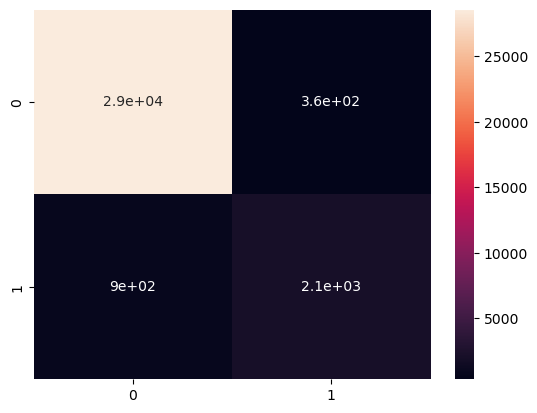


severe_toxic
AUC Score: 0.6376076082409722
Accuracy: 0.9905373648754504
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31609
           1       0.51      0.28      0.36       306

    accuracy                           0.99     31915
   macro avg       0.75      0.64      0.68     31915
weighted avg       0.99      0.99      0.99     31915



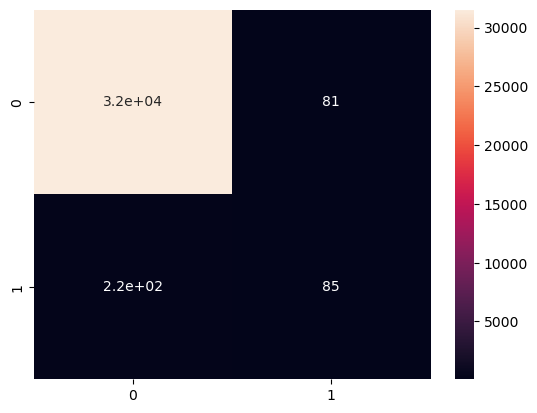


obscene
AUC Score: 0.8512158484445967
Accuracy: 0.9794140686197713
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     30221
           1       0.88      0.71      0.78      1694

    accuracy                           0.98     31915
   macro avg       0.93      0.85      0.89     31915
weighted avg       0.98      0.98      0.98     31915



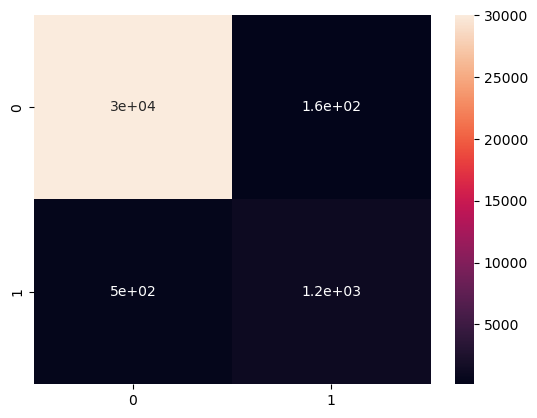


threat
AUC Score: 0.6624306979110208
Accuracy: 0.9978066739777534
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31832
           1       0.66      0.33      0.44        83

    accuracy                           1.00     31915
   macro avg       0.83      0.66      0.72     31915
weighted avg       1.00      1.00      1.00     31915



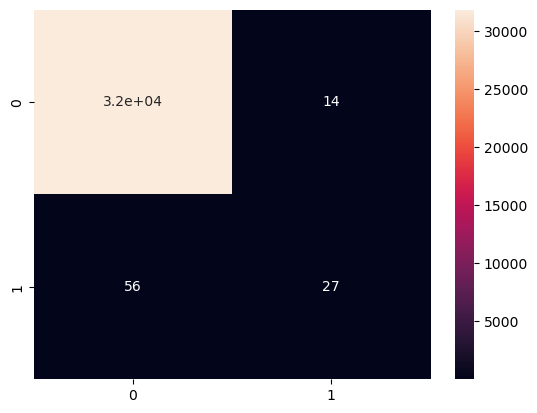


insult
AUC Score: 0.7829658820525405
Accuracy: 0.9708600971330096
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30356
           1       0.77      0.57      0.66      1559

    accuracy                           0.97     31915
   macro avg       0.87      0.78      0.82     31915
weighted avg       0.97      0.97      0.97     31915



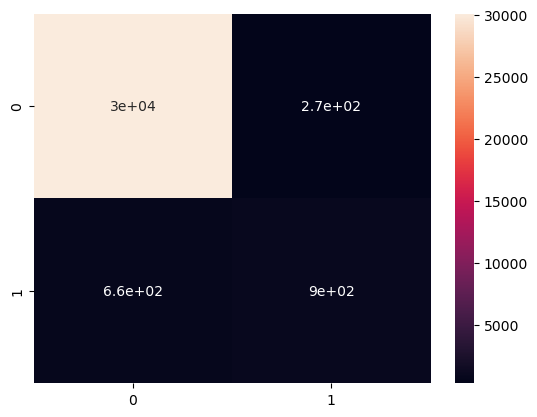


identity_hate
AUC Score: 0.6309313527145873
Accuracy: 0.991947360175466
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31638
           1       0.58      0.26      0.36       277

    accuracy                           0.99     31915
   macro avg       0.79      0.63      0.68     31915
weighted avg       0.99      0.99      0.99     31915



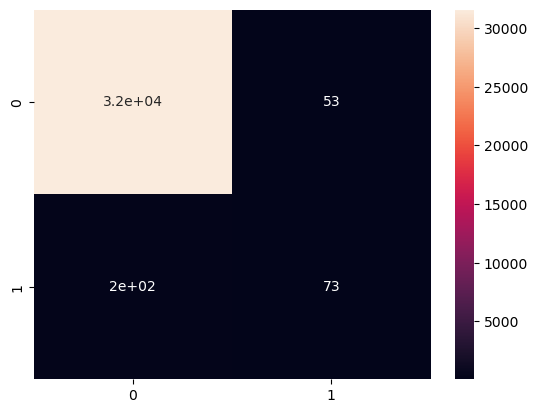

In [26]:
# Evaluate our model
for column in pred_df.columns:
    print(column)
    print('AUC Score:', roc_auc_score(y_test[column], pred_df[column]))
    print('Accuracy:', accuracy_score(y_test[column], pred_df[column]))
    print(classification_report(y_test[column], pred_df[column], zero_division=1))
    sns.heatmap(confusion_matrix(y_test[column], pred_df[column]), annot=True)
    plt.show()
    print()

### Model Tuning ###

Our Gridsearch trials revealed:
<ul>
<li> A more optimal C of 1.5
<li> Our model was better off without any kernel approximation before our LinearSVC. 
<li> A TF-IDF max features of around 15000 scored best
</ul>

Our GridSearch and results are commented out for faster run times. The hyperparameters have been plugged into the model above.

In [27]:
# # Create a gridsearch model
# pipeline_steps = [
#     ("tfidf", tfidf),
#     # ("kernel_approx", Nystroem(kernel='linear')), # Better with no kernel_approximation
#     ("classifier", MultiOutputClassifier(clf))
# ]

# pipeline = Pipeline(steps=pipeline_steps)

# params = {
#     "classifier__estimator__C": [0.5, 1, 1.5, 2], # 1.5 yielded the best results
#     "tfidf__max_features": [5000, 8000, 10000, 15000, 20000]
#     # "kernel_approx__kernel": ['poly', 'linear', 'rbf']
# }

# gs_model = GridSearchCV(estimator=pipeline, param_grid=params)
# gs_model.fit(x_train, y_train)

# best = gs_model.best_estimator_

In [28]:
# predictions = best.predict(x_test)
# df_predictions = pd.DataFrame(predictions, columns=target_cols)

In [29]:
# # Evaluate our model
# for column in target_cols:
#     print(column)
#     print('AUC Score:', roc_auc_score(y_test[column], df_predictions[column]))
#     print('Accuracy:', accuracy_score(y_test[column], df_predictions[column]))
#     print(classification_report(y_test[column], df_predictions[column], zero_division=1))
#     # sns.heatmap(confusion_matrix(y_test[column], df_predictions[column]), annot=True)
#     plt.show()
#     print()

### Final Training ###

Train our model on all of the training data so our TF-IDF is fitted on a larger corpus and our classifier can learn to predictions using more angry and non-angry comments.

In [30]:
# Final model
best = pipe_

# Train on all of the data
# x_clean is all of the preprocessed train_df comments 
best.fit(x_clean, y_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=15000, strip_accents='unicode')),
                ('model', MultiOutputClassifier(estimator=LinearSVC(C=1.5)))])

## Test Data

In [31]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


Preprocessing our test data increases its chances of its tokenized text to be meaningful to our model.

In [32]:
# Preprocessing
test_clean = [clean(x) for x in test_df['comment_text']]

### Make Classifications on the Test Data ###

In [33]:
# Make predictions
test_preds = best.predict(test_clean)

In [34]:
# Create a dataframe of our classifications
test_preds_df = pd.DataFrame(test_preds, columns=target_cols)
test_preds_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,1,0,1,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
153159,0,0,0,0,0,0
153160,0,0,0,0,0,0
153161,0,0,0,0,0,0
153162,0,0,0,0,0,0


## Output Details, Submission Info, and Example Submission


For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [35]:
out_df = pd.concat([test_df['id'], test_preds_df], axis=1)
out_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,0,1,0,1,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0


In [36]:
# Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
# This command should work with your dataframe of predictions. 
out_df.to_csv('out.csv', index=False)  

### Evaluating Our Classifications on the Test Data ###

View some of the classifications we made to see if they are reasonable since there are no target columns to evaluate accuracy.

In [37]:
# Picking out a single terrible comment
test_df.iloc[141859]['comment_text']

'" \n : \n :*""I hope you die of something you ate""  \n :*""She got shot with the whore makeup gun?""  \n :*""Vani you ignorant slut""  \n :*""get some real dick in your boney ass diet""  \n :*""when I called you a \'dumb cunt\' I did not mean to imply you were a \'dumb woman\' [...] I think you are a dumb human being"" \n :*""you are a stupid female. kill yourself."" \n :*""This is just for you Food Babe you\'re an ugly twat"" (Image captioned ""What organ stays warm inside of a dead girl\'s body? My Dick"") \n :Top quality criticism from the scientific community m8...   "'

In [38]:
# Our predictions for the above comment
out_df.iloc[141859]

id               141860
toxic                 1
severe_toxic          1
obscene               1
threat                0
insult                1
identity_hate         0
Name: 141859, dtype: int64

In [39]:
# View some of the comments classified as threats
threats = out_df[out_df['threat'] == 1].index.to_list()
test_df.iloc[threats]['comment_text'].sample(15)

128761    :SHUT UP, YOU STUPID KID, OR I WILL KICK YOUR ...
66577     == E dog == \n\n I Know where you live and i'm...
148828    YOUR GOING TO DIE..  \n\n YOUR GOING TO DIE.. ...
137808    == Veritas comments. == \n\n Do not get offend...
55679     Wow G3 my ass, you just slandered me....go bur...
126661    " \n\n == The thing to be done about the Arabs...
44015     Griggs was definatly shot in the head. Just be...
43680     KICK ME OFF DICK HEADS TRY IT>>>>>>>>>>>>>>>IL...
59626            == Hi, Netsnipe! == \n\n I hope you die. )
27914     " \n :  SEZ> That's true. I ""discovered"" the...
58505     " \n\n ==  Nazi Germany and ""real Germany"" a...
51109     I'm a fucking Nazi and I want to kill all Chin...
19037     ==you are off your head.. adding spec is good,...
15523     iBEWARE WHOEVER OWNS GOOGLE!! I KILL YOU AND M...
139538    abowhy am i not dead right now some one kill m...
Name: comment_text, dtype: object

In [41]:
# View some of the comments that are non-angry
all_0 = out_df[out_df.iloc[:, 1:].sum(axis=1) == 0].index.to_list()
test_df.iloc[all_0]['comment_text'].sample(15)

43651     "The term 'tense' would seem to be the least u...
86839     ==Signature== \n Jay, perhaps you can help me ...
21653     == Please stop! == \n\n Please, please, please...
39593            REDIRECT Talk:Superior Ultraman 8 Brothers
124333    " \n\n There are two proposals here: \n * Rest...
112518    == Vandalism == \n\n Hi James, we have an IP a...
114456    " \n\n == Russian State Siberian Corporation =...
27878     " \n\n  Please do not vandalize pages, as you ...
151852    We don't want Zundel-trash and white supremaci...
106052    *I think the current guideline on cite templat...
99903     ==people calm, my eye== \n Today sunday at 1pm...
54100     ==Thanks for your voting!== \n  Hi, thanks for...
146155                " \n : okay i withdraw the article  "
16497     == Thanks, aargh == \n\n Thanks for your kind ...
52969                    ==Herschel Grynszpan== \n IS DEAD.
Name: comment_text, dtype: object

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>